In [1]:
# Code from https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import shutil
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from keras.utils.layer_utils import count_params
from time import time

In [2]:
seed = 2802
test_size = 0.2
batch_size = 32

input_dir = "data/images"
target_dir = "data/mask"

input_shape = (320,320)

filters1 = [48, 64, 96]
filters2 = [128, 192,256]

step = 50
epochs = 300

In [3]:
df = pd.read_csv('data/dataset_train_test.csv') 
df['piece'] = df['part'].apply(lambda x: int(x[1:]))
df['path'] = input_dir+'/'+df['image_name']+'.jpg'
df['category'] = np.where(df['class']==1, 0, np.where(df['class']==2, 0, 1)) #class_mode binary 1: NOBURR / 0 BURR

df.head()

,Unnamed: 0,image_name,part,section,min_height,max_height,diff_height,piece_position,class,image_id,set,piece,path,category
0,0,P01_001_0,P01,0,181,200,19,Down,2,1,Train,1,data/images/P01_001_0.jpg,0
1,1,P01_001_1,P01,1,198,208,10,Down,1,1,Train,1,data/images/P01_001_1.jpg,0
2,2,P01_001_2,P01,2,204,214,10,Down,1,1,Train,1,data/images/P01_001_2.jpg,0
3,3,P01_001_3,P01,3,200,212,12,Down,1,1,Train,1,data/images/P01_001_3.jpg,0
4,4,P01_002_0,P01,0,232,238,6,Down,1,2,Train,1,data/images/P01_002_0.jpg,0


In [4]:
datagen_normal = ImageDataGenerator(rescale=1./255)

train_generator_normal = datagen_normal.flow_from_dataframe(
    df[df['set']=='Train'],
    x_col='path', 
    y_col='category', 
    target_size=input_shape, 
    batch_size=batch_size,
    seed=seed,
    class_mode="raw",
    shuffle=True,)

validation_generator_normal = datagen_normal.flow_from_dataframe(
    df[df['set']=='Test'],
    x_col='path', 
    y_col='category', 
    target_size=input_shape, 
    batch_size=batch_size,
    class_mode="raw",
    seed=seed,
    shuffle=True,)

Found 856 validated image filenames.
Found 215 validated image filenames.


In [5]:
counts = np.bincount(train_generator_normal.labels)
total = counts[0]+counts[1]
weight_for_0 = (1 / counts[0]) * (total / 2.0)
weight_for_1 = (1 / counts[1]) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
counts, class_weight

(array([663, 193], dtype=int64),
 {0: 0.6455505279034691, 1: 2.2176165803108807})

In [6]:
def get_model(activation='relu', f1=48, f2=128, k1=17, k2=11, pool=7):
    model = keras.models.Sequential([
        keras.layers.Conv2D(filters=f1, kernel_size=(k1,k1), strides=(4,4), activation=activation, input_shape=(input_shape[0],input_shape[1],3), name='conv1'),
        keras.layers.BatchNormalization(name='batch1'),
        keras.layers.MaxPool2D(pool_size=(pool,pool), strides=(2,2), name='maxpool1'),
        keras.layers.Conv2D(filters=f2, kernel_size=(k2,k2), strides=(1,1), activation=activation, padding="same", name='conv2'),
        keras.layers.BatchNormalization(name='batch2'),
        keras.layers.GlobalAveragePooling2D(name='avg'),
        keras.layers.Dense(int(f2/2), activation=activation, name='dense1'),
        keras.layers.Dense(int(f2/4), activation=activation, name='dense2'),
        keras.layers.Dense(1, activation='sigmoid', name='denses')
    ])
    return model

In [7]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=50,decay_rate=0.9)

optimizers = [    
    {'opt': keras.optimizers.Adam(learning_rate=lr_schedule), 'name':'adam_exponential', 'id':'gradual'},
    {'opt': keras.optimizers.Adam(learning_rate=0.000001), 'name':'adam_0.000001', 'id':'fixed'},
]

losses= [ 
    {
    'name': 'normal',
    'loss': tf.keras.losses.BinaryCrossentropy(label_smoothing=0.15),
    'train' : train_generator_normal,
    'val': validation_generator_normal, 
    'cweights' : None
    },
    {
    'name': 'weighted',
    'loss': tf.keras.losses.BinaryCrossentropy(label_smoothing=0.15),
    'train' : train_generator_normal,
    'val': validation_generator_normal, 
    'cweights' : class_weight
    }
]

{'name': 'normal', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8408>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': None}
small_alexnet_adam_exponential_normal_f_48_128


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_normal_f_48_128\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_normal_f_48_128\assets


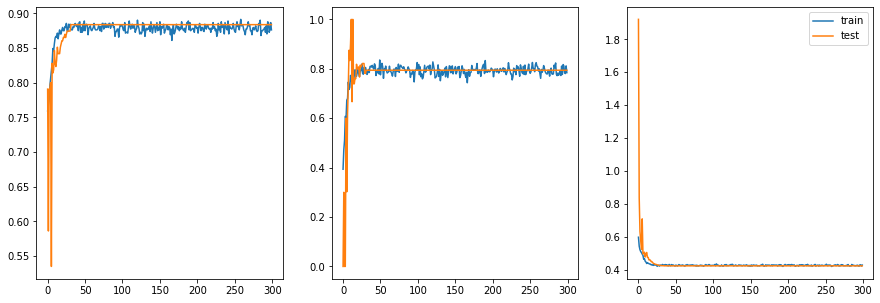

small_alexnet_adam_exponential_normal_f_48_128





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
1,gradual,normal,100,48,128,0.883178,0.883721,0.825175,0.794118,0.611399,0.6,118.0,27.0,638.0,163.0,25.0,7.0,75.0,18.0
2,gradual,normal,150,48,128,0.876168,0.883721,0.800000,0.794118,0.601036,0.6,116.0,27.0,634.0,163.0,29.0,7.0,77.0,18.0
3,gradual,normal,200,48,128,0.878505,0.883721,0.798658,0.794118,0.616580,0.6,119.0,27.0,633.0,163.0,30.0,7.0,74.0,18.0
4,gradual,normal,250,48,128,0.877336,0.883721,0.789474,0.794118,0.621762,0.6,120.0,27.0,631.0,163.0,32.0,7.0,73.0,18.0
5,gradual,normal,300,48,128,0.876168,0.883721,0.784314,0.794118,0.621762,0.6,120.0,27.0,630.0,163.0,33.0,7.0,73.0,18.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
0,gradual,normal,48,128,708.09402,795937,352


{'name': 'normal', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8408>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': None}
small_alexnet_adam_exponential_normal_f_48_192


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_normal_f_48_192\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_normal_f_48_192\assets


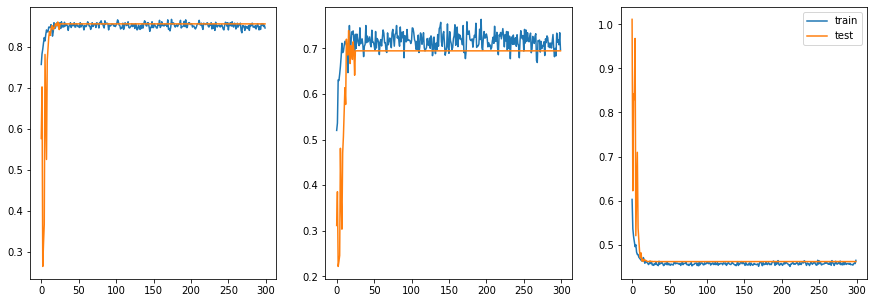

small_alexnet_adam_exponential_normal_f_48_192





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
7,gradual,normal,100,48,192,0.849299,0.855814,0.710526,0.694444,0.559586,0.555556,108.0,25.0,619.0,159.0,44.0,11.0,85.0,20.0
8,gradual,normal,150,48,192,0.846963,0.855814,0.701299,0.694444,0.559586,0.555556,108.0,25.0,617.0,159.0,46.0,11.0,85.0,20.0
9,gradual,normal,200,48,192,0.853972,0.855814,0.723684,0.694444,0.569948,0.555556,110.0,25.0,621.0,159.0,42.0,11.0,83.0,20.0
10,gradual,normal,250,48,192,0.858645,0.855814,0.727848,0.694444,0.595855,0.555556,115.0,25.0,620.0,159.0,43.0,11.0,78.0,20.0
11,gradual,normal,300,48,192,0.845794,0.855814,0.696774,0.694444,0.559586,0.555556,108.0,25.0,616.0,159.0,47.0,11.0,85.0,20.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
0,gradual,normal,48,128,708.094020,795937,352
1,gradual,normal,48,192,694.696595,1180705,480


{'name': 'normal', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8408>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': None}
small_alexnet_adam_exponential_normal_f_48_256


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_normal_f_48_256\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_normal_f_48_256\assets


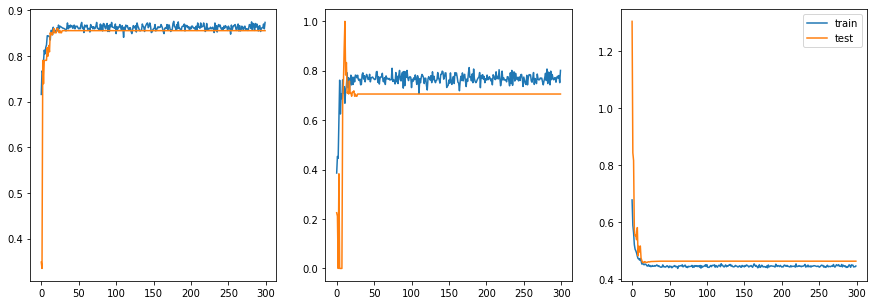

small_alexnet_adam_exponential_normal_f_48_256





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
13,gradual,normal,100,48,256,0.870327,0.855814,0.773333,0.705882,0.601036,0.533333,116.0,24.0,629.0,160.0,34.0,10.0,77.0,21.0
14,gradual,normal,150,48,256,0.857477,0.855814,0.741497,0.705882,0.564767,0.533333,109.0,24.0,625.0,160.0,38.0,10.0,84.0,21.0
15,gradual,normal,200,48,256,0.863318,0.855814,0.767606,0.705882,0.564767,0.533333,109.0,24.0,630.0,160.0,33.0,10.0,84.0,21.0
16,gradual,normal,250,48,256,0.856308,0.855814,0.736486,0.705882,0.564767,0.533333,109.0,24.0,624.0,160.0,39.0,10.0,84.0,21.0
17,gradual,normal,300,48,256,0.873832,0.855814,0.801418,0.705882,0.585492,0.533333,113.0,24.0,635.0,160.0,28.0,10.0,80.0,21.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
0,gradual,normal,48,128,708.094020,795937,352
1,gradual,normal,48,192,694.696595,1180705,480
2,gradual,normal,48,256,680.447709,1570593,608


{'name': 'normal', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8408>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': None}
small_alexnet_adam_exponential_normal_f_64_128


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_normal_f_64_128\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_normal_f_64_128\assets


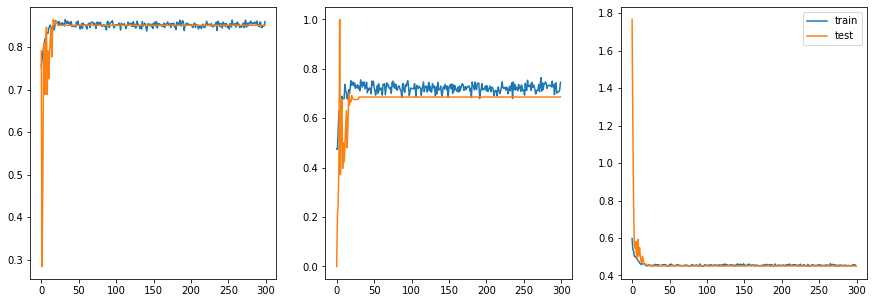

small_alexnet_adam_exponential_normal_f_64_128





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
19,gradual,normal,100,64,128,0.852804,0.851163,0.721854,0.685714,0.564767,0.533333,109.0,24.0,621.0,159.0,42.0,11.0,84.0,21.0
20,gradual,normal,150,64,128,0.843458,0.851163,0.685535,0.685714,0.564767,0.533333,109.0,24.0,613.0,159.0,50.0,11.0,84.0,21.0
21,gradual,normal,200,64,128,0.852804,0.851163,0.731034,0.685714,0.549223,0.533333,106.0,24.0,624.0,159.0,39.0,11.0,87.0,21.0
22,gradual,normal,250,64,128,0.845794,0.851163,0.710345,0.685714,0.533679,0.533333,103.0,24.0,621.0,159.0,42.0,11.0,90.0,21.0
23,gradual,normal,300,64,128,0.859813,0.851163,0.744966,0.685714,0.575130,0.533333,111.0,24.0,625.0,159.0,38.0,11.0,82.0,21.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
0,gradual,normal,48,128,708.094020,795937,352
1,gradual,normal,48,192,694.696595,1180705,480
2,gradual,normal,48,256,680.447709,1570593,608
3,gradual,normal,64,128,734.797193,1057665,384


{'name': 'normal', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8408>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': None}
small_alexnet_adam_exponential_normal_f_64_192


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_normal_f_64_192\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_normal_f_64_192\assets


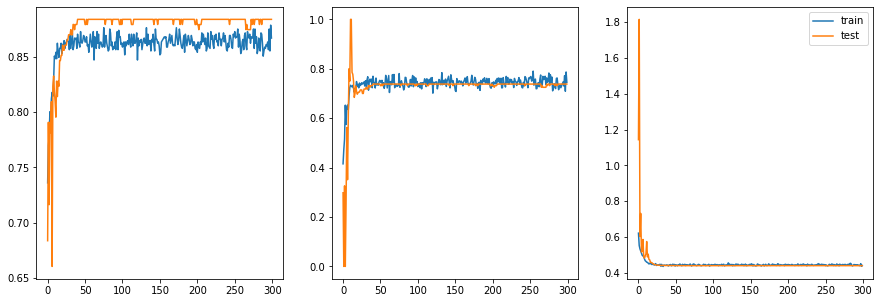

small_alexnet_adam_exponential_normal_f_64_192





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
25,gradual,normal,100,64,192,0.862150,0.879070,0.748344,0.731707,0.585492,0.666667,113.0,30.0,625.0,159.0,38.0,11.0,80.0,15.0
26,gradual,normal,150,64,192,0.859813,0.883721,0.732484,0.738095,0.595855,0.688889,115.0,31.0,621.0,159.0,42.0,11.0,78.0,14.0
27,gradual,normal,200,64,192,0.860981,0.883721,0.743421,0.738095,0.585492,0.688889,113.0,31.0,624.0,159.0,39.0,11.0,80.0,14.0
28,gradual,normal,250,64,192,0.867991,0.883721,0.759740,0.738095,0.606218,0.688889,117.0,31.0,626.0,159.0,37.0,11.0,76.0,14.0
29,gradual,normal,300,64,192,0.866822,0.883721,0.745342,0.738095,0.621762,0.688889,120.0,31.0,622.0,159.0,41.0,11.0,73.0,14.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
0,gradual,normal,48,128,708.094020,795937,352
1,gradual,normal,48,192,694.696595,1180705,480
2,gradual,normal,48,256,680.447709,1570593,608
3,gradual,normal,64,128,734.797193,1057665,384
4,gradual,normal,64,192,751.649974,1566337,512


{'name': 'normal', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8408>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': None}
small_alexnet_adam_exponential_normal_f_64_256


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_normal_f_64_256\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_normal_f_64_256\assets


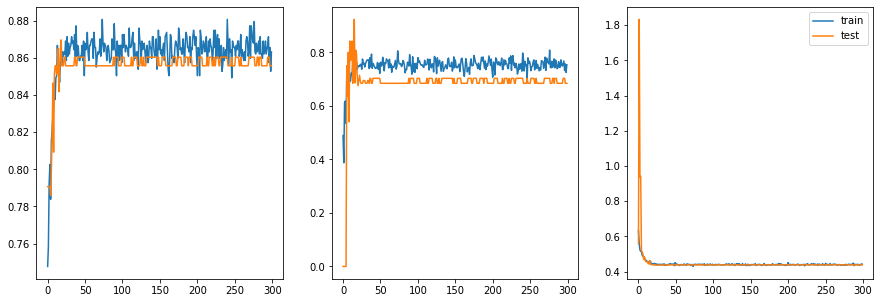

small_alexnet_adam_exponential_normal_f_64_256





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
31,gradual,normal,100,64,256,0.857477,0.860465,0.738255,0.702703,0.569948,0.577778,110.0,26.0,624.0,159.0,39.0,11.0,83.0,19.0
32,gradual,normal,150,64,256,0.864486,0.855814,0.742138,0.684211,0.611399,0.577778,118.0,26.0,622.0,158.0,41.0,12.0,75.0,19.0
33,gradual,normal,200,64,256,0.860981,0.855814,0.734177,0.684211,0.601036,0.577778,116.0,26.0,621.0,158.0,42.0,12.0,77.0,19.0
34,gradual,normal,250,64,256,0.865654,0.855814,0.767123,0.684211,0.580311,0.577778,112.0,26.0,629.0,158.0,34.0,12.0,81.0,19.0
35,gradual,normal,300,64,256,0.863318,0.855814,0.753333,0.684211,0.585492,0.577778,113.0,26.0,626.0,158.0,37.0,12.0,80.0,19.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
1,gradual,normal,48,192,694.696595,1180705,480
2,gradual,normal,48,256,680.447709,1570593,608
3,gradual,normal,64,128,734.797193,1057665,384
4,gradual,normal,64,192,751.649974,1566337,512
5,gradual,normal,64,256,720.249816,2080129,640


{'name': 'normal', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8408>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': None}
small_alexnet_adam_exponential_normal_f_96_128


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_normal_f_96_128\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_normal_f_96_128\assets


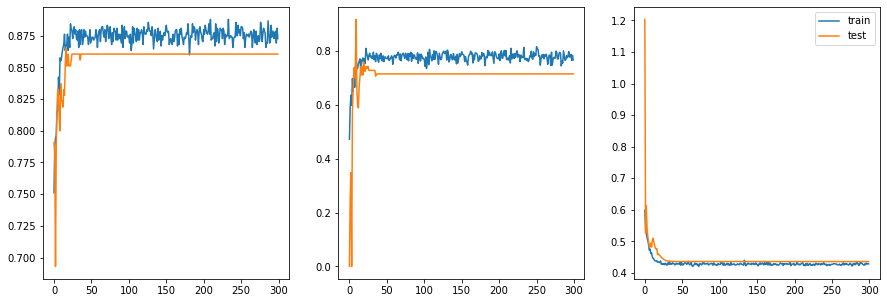

small_alexnet_adam_exponential_normal_f_96_128





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
37,gradual,normal,100,96,128,0.875000,0.860465,0.772152,0.714286,0.632124,0.555556,122.0,25.0,627.0,160.0,36.0,10.0,71.0,20.0
38,gradual,normal,150,96,128,0.878505,0.860465,0.783440,0.714286,0.637306,0.555556,123.0,25.0,629.0,160.0,34.0,10.0,70.0,20.0
39,gradual,normal,200,96,128,0.870327,0.860465,0.769737,0.714286,0.606218,0.555556,117.0,25.0,628.0,160.0,35.0,10.0,76.0,20.0
40,gradual,normal,250,96,128,0.875000,0.860465,0.782895,0.714286,0.616580,0.555556,119.0,25.0,630.0,160.0,33.0,10.0,74.0,20.0
41,gradual,normal,300,96,128,0.872664,0.860465,0.765823,0.714286,0.626943,0.555556,121.0,25.0,626.0,160.0,37.0,10.0,72.0,20.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
2,gradual,normal,48,256,680.447709,1570593,608
3,gradual,normal,64,128,734.797193,1057665,384
4,gradual,normal,64,192,751.649974,1566337,512
5,gradual,normal,64,256,720.249816,2080129,640
6,gradual,normal,96,128,713.676332,1581121,448


{'name': 'normal', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8408>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': None}
small_alexnet_adam_exponential_normal_f_96_192


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_normal_f_96_192\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_normal_f_96_192\assets


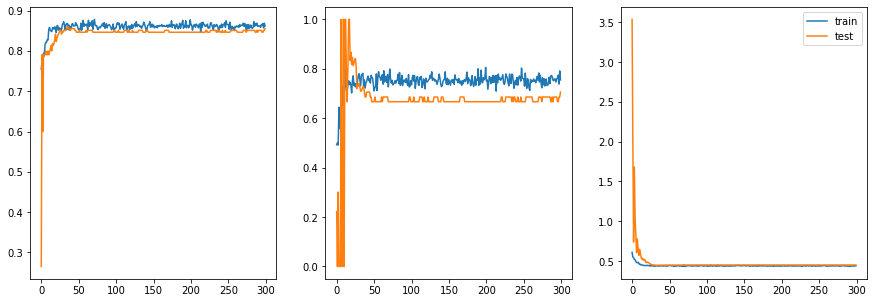

small_alexnet_adam_exponential_normal_f_96_192





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
43,gradual,normal,100,96,192,0.857477,0.846512,0.751773,0.666667,0.549223,0.533333,106.0,24.0,628.0,158.0,35.0,12.0,87.0,21.0
44,gradual,normal,150,96,192,0.859813,0.846512,0.735484,0.666667,0.590674,0.533333,114.0,24.0,622.0,158.0,41.0,12.0,79.0,21.0
45,gradual,normal,200,96,192,0.877336,0.846512,0.805556,0.666667,0.601036,0.533333,116.0,24.0,635.0,158.0,28.0,12.0,77.0,21.0
46,gradual,normal,250,96,192,0.865654,0.846512,0.760000,0.666667,0.590674,0.533333,114.0,24.0,627.0,158.0,36.0,12.0,79.0,21.0
47,gradual,normal,300,96,192,0.862150,0.855814,0.755102,0.705882,0.575130,0.533333,111.0,24.0,627.0,160.0,36.0,10.0,82.0,21.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
3,gradual,normal,64,128,734.797193,1057665,384
4,gradual,normal,64,192,751.649974,1566337,512
5,gradual,normal,64,256,720.249816,2080129,640
6,gradual,normal,96,128,713.676332,1581121,448
7,gradual,normal,96,192,751.771681,2337601,576


{'name': 'normal', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8408>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': None}
small_alexnet_adam_exponential_normal_f_96_256


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_normal_f_96_256\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_normal_f_96_256\assets


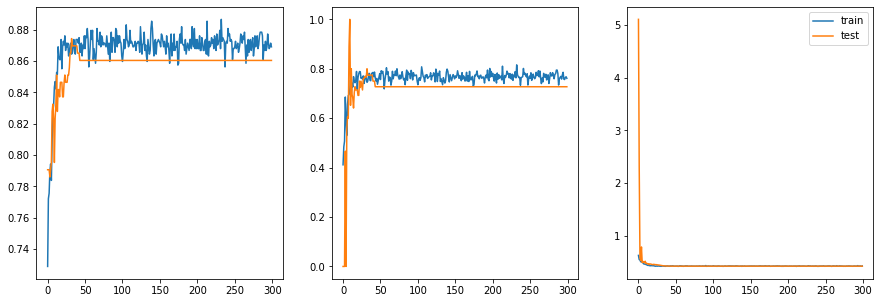

small_alexnet_adam_exponential_normal_f_96_256





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
49,gradual,normal,100,96,256,0.863318,0.860465,0.750000,0.727273,0.590674,0.533333,114.0,24.0,625.0,161.0,38.0,9.0,79.0,21.0
50,gradual,normal,150,96,256,0.872664,0.860465,0.759259,0.727273,0.637306,0.533333,123.0,24.0,624.0,161.0,39.0,9.0,70.0,21.0
51,gradual,normal,200,96,256,0.867991,0.860465,0.770270,0.727273,0.590674,0.533333,114.0,24.0,629.0,161.0,34.0,9.0,79.0,21.0
52,gradual,normal,250,96,256,0.867991,0.860465,0.770270,0.727273,0.590674,0.533333,114.0,24.0,629.0,161.0,34.0,9.0,79.0,21.0
53,gradual,normal,300,96,256,0.869159,0.860465,0.761290,0.727273,0.611399,0.533333,118.0,24.0,626.0,161.0,37.0,9.0,75.0,21.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
4,gradual,normal,64,192,751.649974,1566337,512
5,gradual,normal,64,256,720.249816,2080129,640
6,gradual,normal,96,128,713.676332,1581121,448
7,gradual,normal,96,192,751.771681,2337601,576
8,gradual,normal,96,256,785.417429,3099201,704


{'name': 'normal', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8408>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': None}
small_alexnet_adam_0.000001_normal_f_48_128


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_normal_f_48_128\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_normal_f_48_128\assets


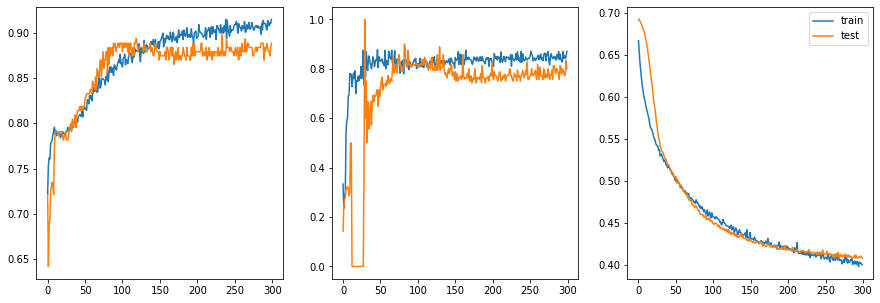

small_alexnet_adam_0.000001_normal_f_48_128





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
55,fixed,normal,100,48,128,0.866822,0.888372,0.801527,0.818182,0.544041,0.600000,105.0,27.0,637.0,164.0,26.0,6.0,88.0,18.0
56,fixed,normal,150,48,128,0.882009,0.869767,0.802632,0.757576,0.632124,0.555556,122.0,25.0,633.0,162.0,30.0,8.0,71.0,20.0
57,fixed,normal,200,48,128,0.893692,0.879070,0.822785,0.827586,0.673575,0.533333,130.0,24.0,635.0,165.0,28.0,5.0,63.0,21.0
58,fixed,normal,250,48,128,0.907710,0.874419,0.843373,0.764706,0.725389,0.577778,140.0,26.0,637.0,162.0,26.0,8.0,53.0,19.0
59,fixed,normal,300,48,128,0.914720,0.888372,0.870370,0.800000,0.730570,0.622222,141.0,28.0,642.0,163.0,21.0,7.0,52.0,17.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
5,gradual,normal,64,256,720.249816,2080129,640
6,gradual,normal,96,128,713.676332,1581121,448
7,gradual,normal,96,192,751.771681,2337601,576
8,gradual,normal,96,256,785.417429,3099201,704
9,fixed,normal,48,128,710.359832,795937,352


{'name': 'normal', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8408>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': None}
small_alexnet_adam_0.000001_normal_f_48_192


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_normal_f_48_192\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_normal_f_48_192\assets


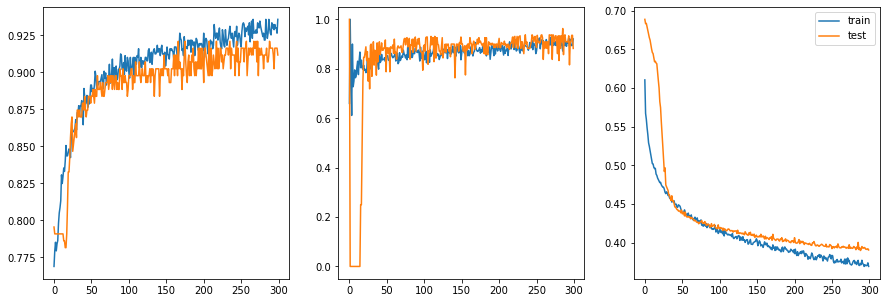

small_alexnet_adam_0.000001_normal_f_48_192





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
61,fixed,normal,100,48,192,0.907710,0.888372,0.865385,0.888889,0.699482,0.533333,135.0,24.0,642.0,167.0,21.0,3.0,58.0,21.0
62,fixed,normal,150,48,192,0.904206,0.902326,0.836364,0.928571,0.715026,0.577778,138.0,26.0,636.0,168.0,27.0,2.0,55.0,19.0
63,fixed,normal,200,48,192,0.914720,0.906977,0.884615,0.903226,0.715026,0.622222,138.0,28.0,645.0,167.0,18.0,3.0,55.0,17.0
64,fixed,normal,250,48,192,0.920561,0.906977,0.861272,0.903226,0.772021,0.622222,149.0,28.0,639.0,167.0,24.0,3.0,44.0,17.0
65,fixed,normal,300,48,192,0.935748,0.911628,0.920732,0.882353,0.782383,0.666667,151.0,30.0,650.0,166.0,13.0,4.0,42.0,15.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
6,gradual,normal,96,128,713.676332,1581121,448
7,gradual,normal,96,192,751.771681,2337601,576
8,gradual,normal,96,256,785.417429,3099201,704
9,fixed,normal,48,128,710.359832,795937,352
10,fixed,normal,48,192,710.729984,1180705,480


{'name': 'normal', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8408>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': None}
small_alexnet_adam_0.000001_normal_f_48_256


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_normal_f_48_256\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_normal_f_48_256\assets


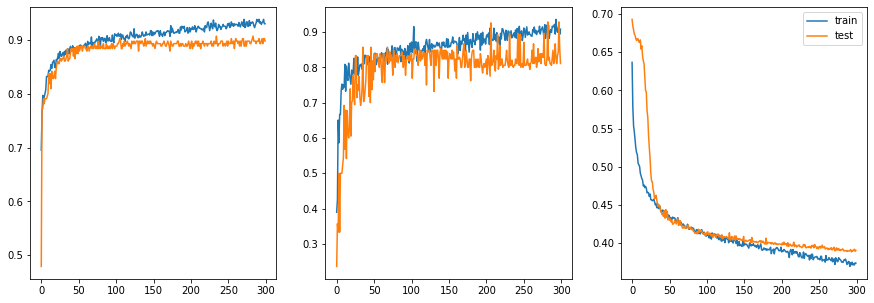

small_alexnet_adam_0.000001_normal_f_48_256





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
67,fixed,normal,100,48,256,0.908879,0.888372,0.844311,0.818182,0.730570,0.600000,141.0,27.0,637.0,164.0,26.0,6.0,52.0,18.0
68,fixed,normal,150,48,256,0.914720,0.888372,0.879747,0.769231,0.720207,0.666667,139.0,30.0,644.0,161.0,19.0,9.0,54.0,15.0
69,fixed,normal,200,48,256,0.914720,0.883721,0.865854,0.812500,0.735751,0.577778,142.0,26.0,641.0,164.0,22.0,6.0,51.0,19.0
70,fixed,normal,250,48,256,0.929907,0.888372,0.888889,0.800000,0.787565,0.622222,152.0,28.0,644.0,163.0,19.0,7.0,41.0,17.0
71,fixed,normal,300,48,256,0.929907,0.897674,0.907975,0.810811,0.766839,0.666667,148.0,30.0,648.0,163.0,15.0,7.0,45.0,15.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
7,gradual,normal,96,192,751.771681,2337601,576
8,gradual,normal,96,256,785.417429,3099201,704
9,fixed,normal,48,128,710.359832,795937,352
10,fixed,normal,48,192,710.729984,1180705,480
11,fixed,normal,48,256,739.469911,1570593,608


{'name': 'normal', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8408>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': None}
small_alexnet_adam_0.000001_normal_f_64_128


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_normal_f_64_128\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_normal_f_64_128\assets


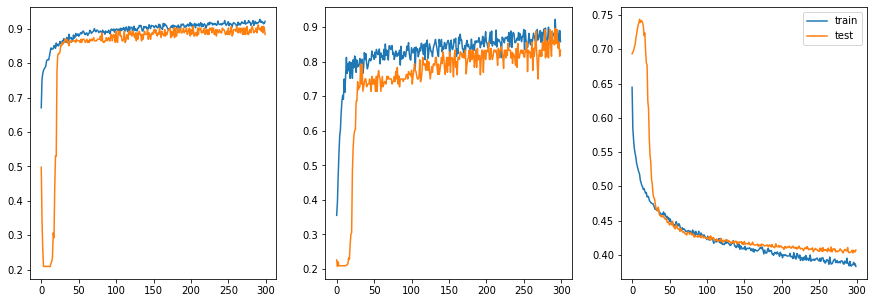

small_alexnet_adam_0.000001_normal_f_64_128





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
73,fixed,normal,100,64,128,0.894860,0.860465,0.804734,0.758621,0.704663,0.488889,136.0,22.0,630.0,163.0,33.0,7.0,57.0,23.0
74,fixed,normal,150,64,128,0.908879,0.883721,0.861635,0.812500,0.709845,0.577778,137.0,26.0,641.0,164.0,22.0,6.0,56.0,19.0
75,fixed,normal,200,64,128,0.918224,0.879070,0.886792,0.806452,0.730570,0.555556,141.0,25.0,645.0,164.0,18.0,6.0,52.0,20.0
76,fixed,normal,250,64,128,0.918224,0.883721,0.872727,0.833333,0.746114,0.555556,144.0,25.0,642.0,165.0,21.0,5.0,49.0,20.0
77,fixed,normal,300,64,128,0.921729,0.883721,0.857955,0.833333,0.782383,0.555556,151.0,25.0,638.0,165.0,25.0,5.0,42.0,20.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
8,gradual,normal,96,256,785.417429,3099201,704
9,fixed,normal,48,128,710.359832,795937,352
10,fixed,normal,48,192,710.729984,1180705,480
11,fixed,normal,48,256,739.469911,1570593,608
12,fixed,normal,64,128,750.276494,1057665,384


{'name': 'normal', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8408>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': None}
small_alexnet_adam_0.000001_normal_f_64_192


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_normal_f_64_192\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_normal_f_64_192\assets


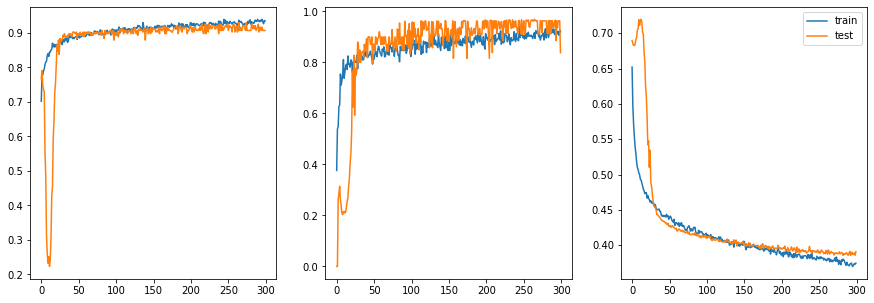

small_alexnet_adam_0.000001_normal_f_64_192





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
79,fixed,normal,100,64,192,0.893692,0.893023,0.822785,0.923077,0.673575,0.533333,130.0,24.0,635.0,168.0,28.0,2.0,63.0,21.0
80,fixed,normal,150,64,192,0.911215,0.911628,0.846154,0.933333,0.740933,0.622222,143.0,28.0,637.0,168.0,26.0,2.0,50.0,17.0
81,fixed,normal,200,64,192,0.928738,0.920930,0.912500,0.966667,0.756477,0.644444,146.0,29.0,649.0,169.0,14.0,1.0,47.0,16.0
82,fixed,normal,250,64,192,0.926402,0.925581,0.896341,0.939394,0.761658,0.688889,147.0,31.0,646.0,168.0,17.0,2.0,46.0,14.0
83,fixed,normal,300,64,192,0.934579,0.906977,0.920245,0.837838,0.777202,0.688889,150.0,31.0,650.0,164.0,13.0,6.0,43.0,14.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
9,fixed,normal,48,128,710.359832,795937,352
10,fixed,normal,48,192,710.729984,1180705,480
11,fixed,normal,48,256,739.469911,1570593,608
12,fixed,normal,64,128,750.276494,1057665,384
13,fixed,normal,64,192,2224.877637,1566337,512


{'name': 'normal', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8408>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': None}
small_alexnet_adam_0.000001_normal_f_64_256


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_normal_f_64_256\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_normal_f_64_256\assets


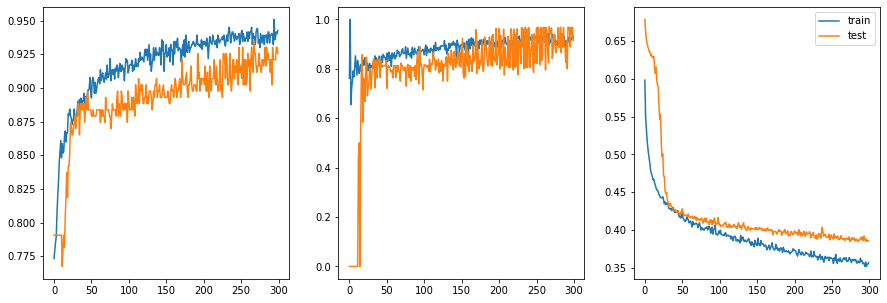

,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
85,fixed,normal,100,64,256,0.911215,0.897674,0.872611,0.794872,0.709845,0.688889,137.0,31.0,643.0,162.0,20.0,8.0,56.0,14.0
86,fixed,normal,150,64,256,0.926402,0.893023,0.896341,0.805556,0.761658,0.644444,147.0,29.0,646.0,163.0,17.0,7.0,46.0,16.0
87,fixed,normal,200,64,256,0.934579,0.906977,0.910180,0.857143,0.787565,0.666667,152.0,30.0,648.0,165.0,15.0,5.0,41.0,15.0
88,fixed,normal,250,64,256,0.935748,0.911628,0.931250,0.825000,0.772021,0.733333,149.0,33.0,652.0,163.0,11.0,7.0,44.0,12.0
89,fixed,normal,300,64,256,0.942757,0.925581,0.928571,0.914286,0.808290,0.711111,156.0,32.0,651.0,167.0,12.0,3.0,37.0,13.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
10,fixed,normal,48,192,710.729984,1180705,480
11,fixed,normal,48,256,739.469911,1570593,608
12,fixed,normal,64,128,750.276494,1057665,384
13,fixed,normal,64,192,2224.877637,1566337,512
14,fixed,normal,64,256,714.131668,2080129,640


small_alexnet_adam_0.000001_normal_f_64_256





-------------------------------------------
{'name': 'normal', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8408>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': None}
small_alexnet_adam_0.000001_normal_f_96_128


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_normal_f_96_128\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_normal_f_96_128\assets


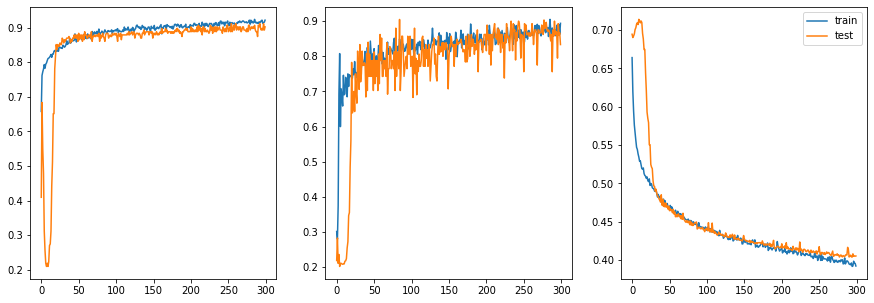

small_alexnet_adam_0.000001_normal_f_96_128





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
91,fixed,normal,100,96,128,0.893692,0.879070,0.849315,0.771429,0.642487,0.600000,124.0,27.0,641.0,162.0,22.0,8.0,69.0,18.0
92,fixed,normal,150,96,128,0.899533,0.869767,0.854305,0.707317,0.668394,0.644444,129.0,29.0,641.0,158.0,22.0,12.0,64.0,16.0
93,fixed,normal,200,96,128,0.908879,0.888372,0.844311,0.862069,0.730570,0.555556,141.0,25.0,637.0,166.0,26.0,4.0,52.0,20.0
94,fixed,normal,250,96,128,0.919393,0.906977,0.869048,0.857143,0.756477,0.666667,146.0,30.0,641.0,165.0,22.0,5.0,47.0,15.0
95,fixed,normal,300,96,128,0.921729,0.902326,0.893750,0.833333,0.740933,0.666667,143.0,30.0,646.0,164.0,17.0,6.0,50.0,15.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
11,fixed,normal,48,256,739.469911,1570593,608
12,fixed,normal,64,128,750.276494,1057665,384
13,fixed,normal,64,192,2224.877637,1566337,512
14,fixed,normal,64,256,714.131668,2080129,640
15,fixed,normal,96,128,711.720026,1581121,448


{'name': 'normal', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8408>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': None}
small_alexnet_adam_0.000001_normal_f_96_192


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_normal_f_96_192\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_normal_f_96_192\assets


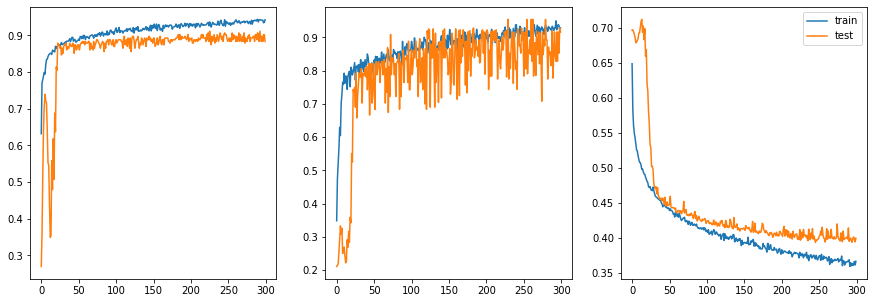

small_alexnet_adam_0.000001_normal_f_96_192





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
97,fixed,normal,100,96,192,0.915888,0.883721,0.862275,0.833333,0.746114,0.555556,144.0,25.0,640.0,165.0,23.0,5.0,49.0,20.0
98,fixed,normal,150,96,192,0.919393,0.879070,0.869048,0.787879,0.756477,0.577778,146.0,26.0,641.0,163.0,22.0,7.0,47.0,19.0
99,fixed,normal,200,96,192,0.932243,0.888372,0.909091,0.888889,0.777202,0.533333,150.0,24.0,648.0,167.0,15.0,3.0,43.0,21.0
100,fixed,normal,250,96,192,0.935748,0.883721,0.915663,0.916667,0.787565,0.488889,152.0,22.0,649.0,168.0,14.0,2.0,41.0,23.0
101,fixed,normal,300,96,192,0.942757,0.883721,0.928571,0.916667,0.808290,0.488889,156.0,22.0,651.0,168.0,12.0,2.0,37.0,23.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
12,fixed,normal,64,128,750.276494,1057665,384
13,fixed,normal,64,192,2224.877637,1566337,512
14,fixed,normal,64,256,714.131668,2080129,640
15,fixed,normal,96,128,711.720026,1581121,448
16,fixed,normal,96,192,719.448355,2337601,576


{'name': 'normal', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8408>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': None}
small_alexnet_adam_0.000001_normal_f_96_256


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_normal_f_96_256\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_normal_f_96_256\assets


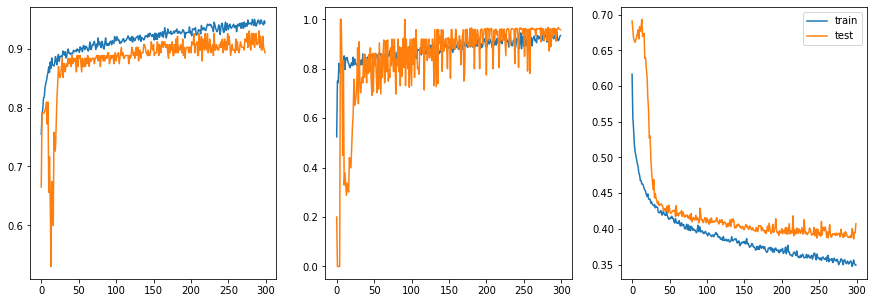

small_alexnet_adam_0.000001_normal_f_96_256





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
103,fixed,normal,100,96,256,0.913551,0.893023,0.874214,0.823529,0.720207,0.622222,139.0,28.0,643.0,164.0,20.0,6.0,54.0,17.0
104,fixed,normal,150,96,256,0.924065,0.897674,0.885542,0.925926,0.761658,0.555556,147.0,25.0,644.0,168.0,19.0,2.0,46.0,20.0
105,fixed,normal,200,96,256,0.926402,0.902326,0.891566,0.961538,0.766839,0.555556,148.0,25.0,645.0,169.0,18.0,1.0,45.0,20.0
106,fixed,normal,250,96,256,0.939252,0.925581,0.932515,0.939394,0.787565,0.688889,152.0,31.0,652.0,168.0,11.0,2.0,41.0,14.0
107,fixed,normal,300,96,256,0.943925,0.893023,0.934132,0.958333,0.808290,0.511111,156.0,23.0,652.0,169.0,11.0,1.0,37.0,22.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
13,fixed,normal,64,192,2224.877637,1566337,512
14,fixed,normal,64,256,714.131668,2080129,640
15,fixed,normal,96,128,711.720026,1581121,448
16,fixed,normal,96,192,719.448355,2337601,576
17,fixed,normal,96,256,763.633130,3099201,704


{'name': 'weighted', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8808>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': {0: 0.6455505279034691, 1: 2.2176165803108807}}
small_alexnet_adam_exponential_weighted_f_48_128


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_weighted_f_48_128\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_weighted_f_48_128\assets


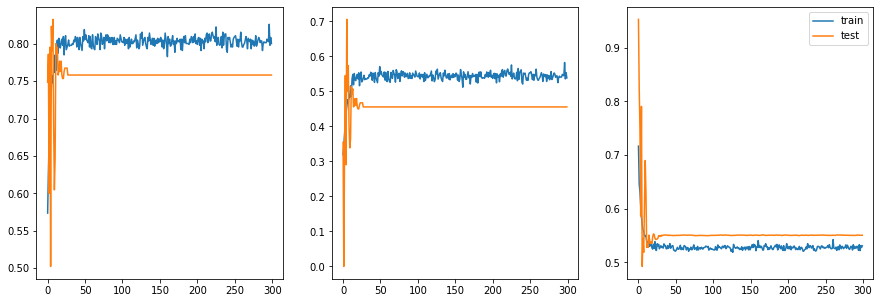

small_alexnet_adam_exponential_weighted_f_48_128





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
109,gradual,weighted,100,48,128,0.802570,0.75814,0.542857,0.455696,0.787565,0.8,152.0,36.0,535.0,127.0,128.0,43.0,41.0,9.0
110,gradual,weighted,150,48,128,0.806075,0.75814,0.548043,0.455696,0.797927,0.8,154.0,36.0,536.0,127.0,127.0,43.0,39.0,9.0
111,gradual,weighted,200,48,128,0.803738,0.75814,0.545455,0.455696,0.777202,0.8,150.0,36.0,538.0,127.0,125.0,43.0,43.0,9.0
112,gradual,weighted,250,48,128,0.808411,0.75814,0.553114,0.455696,0.782383,0.8,151.0,36.0,541.0,127.0,122.0,43.0,42.0,9.0
113,gradual,weighted,300,48,128,0.800234,0.75814,0.538732,0.455696,0.792746,0.8,153.0,36.0,532.0,127.0,131.0,43.0,40.0,9.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
14,fixed,normal,64,256,714.131668,2080129,640
15,fixed,normal,96,128,711.720026,1581121,448
16,fixed,normal,96,192,719.448355,2337601,576
17,fixed,normal,96,256,763.633130,3099201,704
18,gradual,weighted,48,128,718.887050,795937,352


{'name': 'weighted', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8808>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': {0: 0.6455505279034691, 1: 2.2176165803108807}}
small_alexnet_adam_exponential_weighted_f_48_192


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_weighted_f_48_192\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_weighted_f_48_192\assets


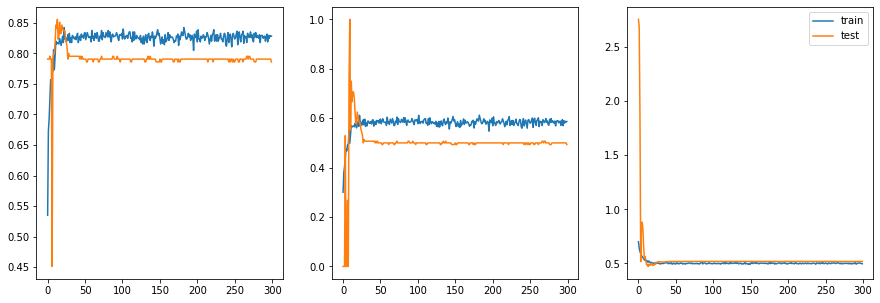

small_alexnet_adam_exponential_weighted_f_48_192





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
115,gradual,weighted,100,48,192,0.832944,0.790698,0.594697,0.500000,0.813471,0.822222,157.0,37.0,556.0,133.0,107.0,37.0,36.0,8.0
116,gradual,weighted,150,48,192,0.832944,0.786047,0.593985,0.493333,0.818653,0.822222,158.0,37.0,555.0,132.0,108.0,38.0,35.0,8.0
117,gradual,weighted,200,48,192,0.836449,0.790698,0.600000,0.500000,0.823834,0.822222,159.0,37.0,557.0,133.0,106.0,37.0,34.0,8.0
118,gradual,weighted,250,48,192,0.828271,0.786047,0.587121,0.493333,0.803109,0.822222,155.0,37.0,554.0,132.0,109.0,38.0,38.0,8.0
119,gradual,weighted,300,48,192,0.828271,0.786047,0.586466,0.493333,0.808290,0.822222,156.0,37.0,553.0,132.0,110.0,38.0,37.0,8.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
15,fixed,normal,96,128,711.720026,1581121,448
16,fixed,normal,96,192,719.448355,2337601,576
17,fixed,normal,96,256,763.633130,3099201,704
18,gradual,weighted,48,128,718.887050,795937,352
19,gradual,weighted,48,192,718.717586,1180705,480


{'name': 'weighted', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8808>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': {0: 0.6455505279034691, 1: 2.2176165803108807}}
small_alexnet_adam_exponential_weighted_f_48_256


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_weighted_f_48_256\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_weighted_f_48_256\assets


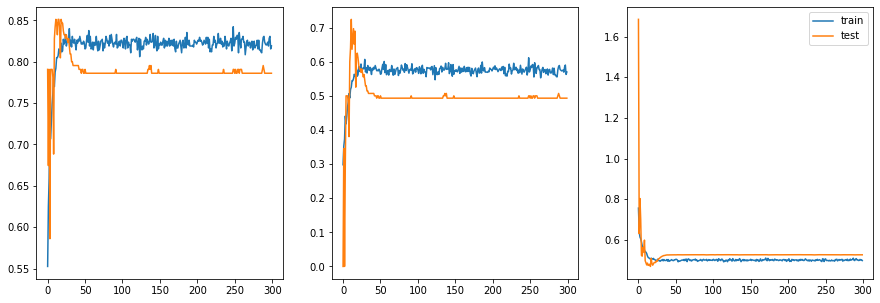

small_alexnet_adam_exponential_weighted_f_48_256





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
121,gradual,weighted,100,48,256,0.825935,0.786047,0.581481,0.493151,0.813471,0.8,157.0,36.0,550.0,133.0,113.0,37.0,36.0,9.0
122,gradual,weighted,150,48,256,0.821262,0.786047,0.572993,0.493151,0.813471,0.8,157.0,36.0,546.0,133.0,117.0,37.0,36.0,9.0
123,gradual,weighted,200,48,256,0.821262,0.786047,0.572993,0.493151,0.813471,0.8,157.0,36.0,546.0,133.0,117.0,37.0,36.0,9.0
124,gradual,weighted,250,48,256,0.818925,0.790698,0.569853,0.500000,0.803109,0.8,155.0,36.0,546.0,134.0,117.0,36.0,38.0,9.0
125,gradual,weighted,300,48,256,0.818925,0.786047,0.569853,0.493151,0.803109,0.8,155.0,36.0,546.0,133.0,117.0,37.0,38.0,9.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
16,fixed,normal,96,192,719.448355,2337601,576
17,fixed,normal,96,256,763.633130,3099201,704
18,gradual,weighted,48,128,718.887050,795937,352
19,gradual,weighted,48,192,718.717586,1180705,480
20,gradual,weighted,48,256,715.261805,1570593,608


{'name': 'weighted', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8808>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': {0: 0.6455505279034691, 1: 2.2176165803108807}}
small_alexnet_adam_exponential_weighted_f_64_128


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_weighted_f_64_128\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_weighted_f_64_128\assets


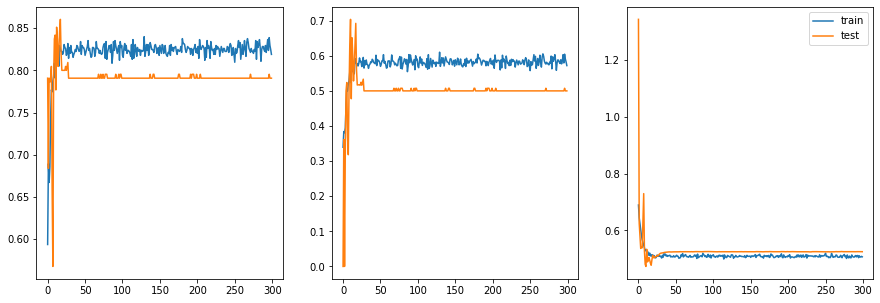

small_alexnet_adam_exponential_weighted_f_64_128





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
127,gradual,weighted,100,64,128,0.829439,0.790698,0.590734,0.500000,0.792746,0.733333,153.0,33.0,557.0,137.0,106.0,33.0,40.0,12.0
128,gradual,weighted,150,64,128,0.817757,0.790698,0.570342,0.500000,0.777202,0.733333,150.0,33.0,550.0,137.0,113.0,33.0,43.0,12.0
129,gradual,weighted,200,64,128,0.825935,0.795349,0.584615,0.507463,0.787565,0.755556,152.0,34.0,555.0,137.0,108.0,33.0,41.0,11.0
130,gradual,weighted,250,64,128,0.817757,0.790698,0.569811,0.500000,0.782383,0.733333,151.0,33.0,549.0,137.0,114.0,33.0,42.0,12.0
131,gradual,weighted,300,64,128,0.818925,0.790698,0.571970,0.500000,0.782383,0.733333,151.0,33.0,550.0,137.0,113.0,33.0,42.0,12.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
17,fixed,normal,96,256,763.633130,3099201,704
18,gradual,weighted,48,128,718.887050,795937,352
19,gradual,weighted,48,192,718.717586,1180705,480
20,gradual,weighted,48,256,715.261805,1570593,608
21,gradual,weighted,64,128,733.265766,1057665,384


{'name': 'weighted', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8808>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': {0: 0.6455505279034691, 1: 2.2176165803108807}}
small_alexnet_adam_exponential_weighted_f_64_192


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_weighted_f_64_192\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_weighted_f_64_192\assets


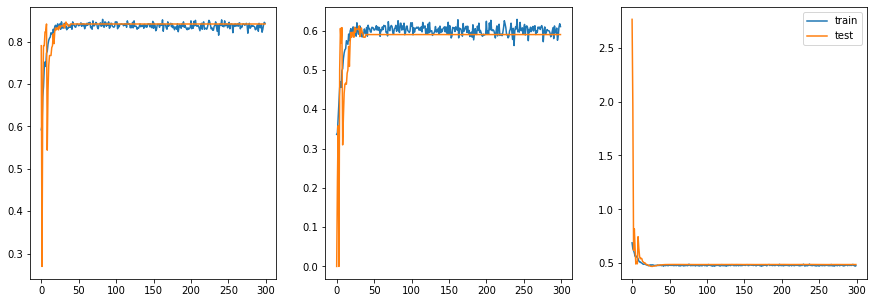

small_alexnet_adam_exponential_weighted_f_64_192





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
133,gradual,weighted,100,64,192,0.846963,0.84186,0.620155,0.590164,0.829016,0.8,160.0,36.0,565.0,145.0,98.0,25.0,33.0,9.0
134,gradual,weighted,150,64,192,0.848131,0.84186,0.621622,0.590164,0.834197,0.8,161.0,36.0,565.0,145.0,98.0,25.0,32.0,9.0
135,gradual,weighted,200,64,192,0.832944,0.84186,0.591241,0.590164,0.839378,0.8,162.0,36.0,551.0,145.0,112.0,25.0,31.0,9.0
136,gradual,weighted,250,64,192,0.832944,0.84186,0.592593,0.590164,0.829016,0.8,160.0,36.0,553.0,145.0,110.0,25.0,33.0,9.0
137,gradual,weighted,300,64,192,0.843458,0.84186,0.610487,0.590164,0.844560,0.8,163.0,36.0,559.0,145.0,104.0,25.0,30.0,9.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
18,gradual,weighted,48,128,718.887050,795937,352
19,gradual,weighted,48,192,718.717586,1180705,480
20,gradual,weighted,48,256,715.261805,1570593,608
21,gradual,weighted,64,128,733.265766,1057665,384
22,gradual,weighted,64,192,761.294282,1566337,512


{'name': 'weighted', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8808>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': {0: 0.6455505279034691, 1: 2.2176165803108807}}
small_alexnet_adam_exponential_weighted_f_64_256


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_weighted_f_64_256\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_weighted_f_64_256\assets


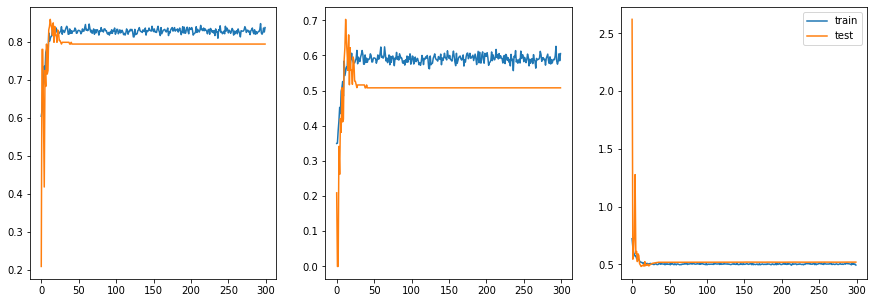

small_alexnet_adam_exponential_weighted_f_64_256





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
139,gradual,weighted,100,64,256,0.821262,0.795349,0.575188,0.507937,0.792746,0.711111,153.0,32.0,550.0,139.0,113.0,31.0,40.0,13.0
140,gradual,weighted,150,64,256,0.832944,0.795349,0.597656,0.507937,0.792746,0.711111,153.0,32.0,560.0,139.0,103.0,31.0,40.0,13.0
141,gradual,weighted,200,64,256,0.834112,0.795349,0.597701,0.507937,0.808290,0.711111,156.0,32.0,558.0,139.0,105.0,31.0,37.0,13.0
142,gradual,weighted,250,64,256,0.834112,0.795349,0.600791,0.507937,0.787565,0.711111,152.0,32.0,562.0,139.0,101.0,31.0,41.0,13.0
143,gradual,weighted,300,64,256,0.838785,0.795349,0.605364,0.507937,0.818653,0.711111,158.0,32.0,560.0,139.0,103.0,31.0,35.0,13.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
19,gradual,weighted,48,192,718.717586,1180705,480
20,gradual,weighted,48,256,715.261805,1570593,608
21,gradual,weighted,64,128,733.265766,1057665,384
22,gradual,weighted,64,192,761.294282,1566337,512
23,gradual,weighted,64,256,729.543007,2080129,640


{'name': 'weighted', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8808>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': {0: 0.6455505279034691, 1: 2.2176165803108807}}
small_alexnet_adam_exponential_weighted_f_96_128


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_weighted_f_96_128\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_weighted_f_96_128\assets


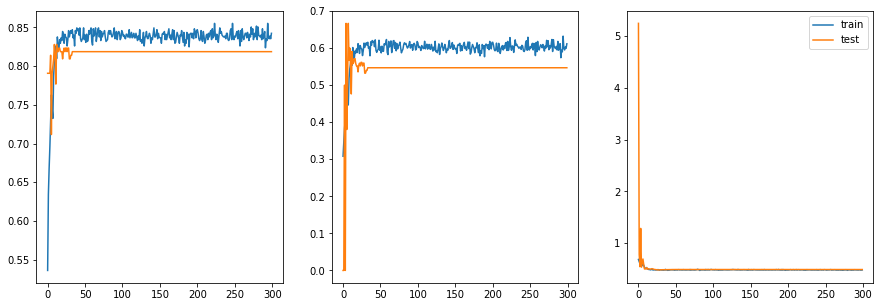

small_alexnet_adam_exponential_weighted_f_96_128





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
145,gradual,weighted,100,96,128,0.845794,0.818605,0.617761,0.546875,0.829016,0.777778,160.0,35.0,564.0,141.0,99.0,29.0,33.0,10.0
146,gradual,weighted,150,96,128,0.837617,0.818605,0.600746,0.546875,0.834197,0.777778,161.0,35.0,556.0,141.0,107.0,29.0,32.0,10.0
147,gradual,weighted,200,96,128,0.845794,0.818605,0.615094,0.546875,0.844560,0.777778,163.0,35.0,561.0,141.0,102.0,29.0,30.0,10.0
148,gradual,weighted,250,96,128,0.834112,0.818605,0.594796,0.546875,0.829016,0.777778,160.0,35.0,554.0,141.0,109.0,29.0,33.0,10.0
149,gradual,weighted,300,96,128,0.842290,0.818605,0.611538,0.546875,0.823834,0.777778,159.0,35.0,562.0,141.0,101.0,29.0,34.0,10.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
20,gradual,weighted,48,256,715.261805,1570593,608
21,gradual,weighted,64,128,733.265766,1057665,384
22,gradual,weighted,64,192,761.294282,1566337,512
23,gradual,weighted,64,256,729.543007,2080129,640
24,gradual,weighted,96,128,768.521015,1581121,448


{'name': 'weighted', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8808>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': {0: 0.6455505279034691, 1: 2.2176165803108807}}
small_alexnet_adam_exponential_weighted_f_96_192


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_weighted_f_96_192\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_weighted_f_96_192\assets


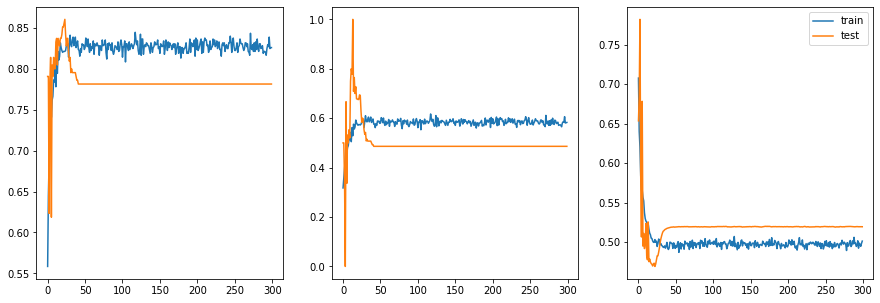

small_alexnet_adam_exponential_weighted_f_96_192





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
151,gradual,weighted,100,96,192,0.829439,0.781395,0.587361,0.486111,0.818653,0.777778,158.0,35.0,552.0,133.0,111.0,37.0,35.0,10.0
152,gradual,weighted,150,96,192,0.827103,0.781395,0.583643,0.486111,0.813471,0.777778,157.0,35.0,551.0,133.0,112.0,37.0,36.0,10.0
153,gradual,weighted,200,96,192,0.823598,0.781395,0.578947,0.486111,0.797927,0.777778,154.0,35.0,551.0,133.0,112.0,37.0,39.0,10.0
154,gradual,weighted,250,96,192,0.827103,0.781395,0.583643,0.486111,0.813471,0.777778,157.0,35.0,551.0,133.0,112.0,37.0,36.0,10.0
155,gradual,weighted,300,96,192,0.825935,0.781395,0.582707,0.486111,0.803109,0.777778,155.0,35.0,552.0,133.0,111.0,37.0,38.0,10.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
21,gradual,weighted,64,128,733.265766,1057665,384
22,gradual,weighted,64,192,761.294282,1566337,512
23,gradual,weighted,64,256,729.543007,2080129,640
24,gradual,weighted,96,128,768.521015,1581121,448
25,gradual,weighted,96,192,760.023650,2337601,576


{'name': 'weighted', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8808>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': {0: 0.6455505279034691, 1: 2.2176165803108807}}
small_alexnet_adam_exponential_weighted_f_96_256


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_weighted_f_96_256\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_exponential_weighted_f_96_256\assets


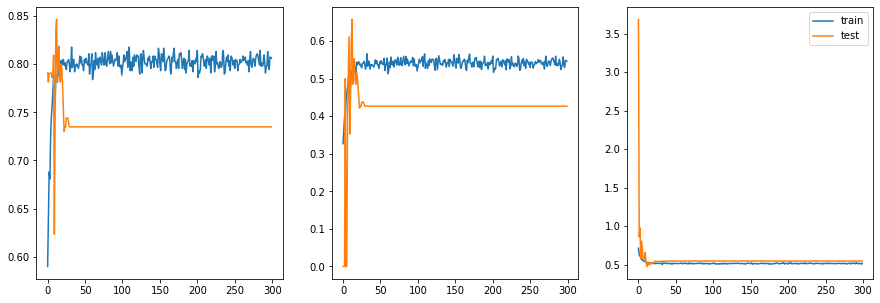

small_alexnet_adam_exponential_weighted_f_96_256





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
157,gradual,weighted,100,96,256,0.788551,0.734884,0.520548,0.426829,0.787565,0.777778,152.0,35.0,523.0,123.0,140.0,47.0,41.0,10.0
158,gradual,weighted,150,96,256,0.810748,0.734884,0.553633,0.426829,0.829016,0.777778,160.0,35.0,534.0,123.0,129.0,47.0,33.0,10.0
159,gradual,weighted,200,96,256,0.802570,0.734884,0.541379,0.426829,0.813471,0.777778,157.0,35.0,530.0,123.0,133.0,47.0,36.0,10.0
160,gradual,weighted,250,96,256,0.803738,0.734884,0.543860,0.426829,0.803109,0.777778,155.0,35.0,533.0,123.0,130.0,47.0,38.0,10.0
161,gradual,weighted,300,96,256,0.806075,0.734884,0.546392,0.426829,0.823834,0.777778,159.0,35.0,531.0,123.0,132.0,47.0,34.0,10.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
22,gradual,weighted,64,192,761.294282,1566337,512
23,gradual,weighted,64,256,729.543007,2080129,640
24,gradual,weighted,96,128,768.521015,1581121,448
25,gradual,weighted,96,192,760.023650,2337601,576
26,gradual,weighted,96,256,807.826938,3099201,704


{'name': 'weighted', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8808>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': {0: 0.6455505279034691, 1: 2.2176165803108807}}
small_alexnet_adam_0.000001_weighted_f_48_128


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_weighted_f_48_128\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_weighted_f_48_128\assets


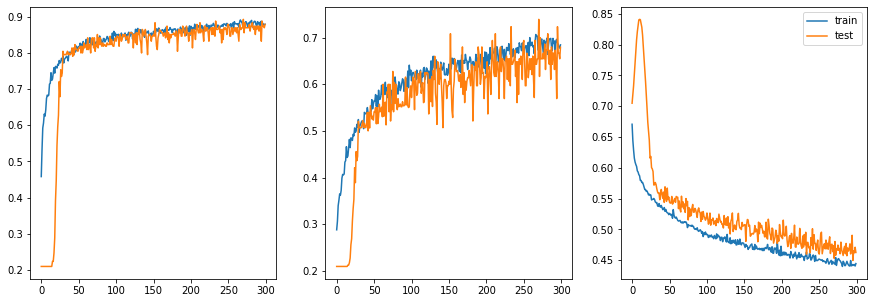

small_alexnet_adam_0.000001_weighted_f_48_128





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
163,fixed,weighted,100,48,128,0.855140,0.841860,0.630189,0.596491,0.865285,0.755556,167.0,34.0,565.0,147.0,98.0,23.0,26.0,11.0
164,fixed,weighted,150,48,128,0.850467,0.846512,0.624521,0.596774,0.844560,0.822222,163.0,37.0,565.0,145.0,98.0,25.0,30.0,8.0
165,fixed,weighted,200,48,128,0.849299,0.851163,0.623077,0.614035,0.839378,0.777778,162.0,35.0,565.0,148.0,98.0,22.0,31.0,10.0
166,fixed,weighted,250,48,128,0.873832,0.879070,0.674897,0.686275,0.849741,0.777778,164.0,35.0,584.0,154.0,79.0,16.0,29.0,10.0
167,fixed,weighted,300,48,128,0.879673,0.879070,0.684426,0.679245,0.865285,0.800000,167.0,36.0,586.0,153.0,77.0,17.0,26.0,9.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
23,gradual,weighted,64,256,729.543007,2080129,640
24,gradual,weighted,96,128,768.521015,1581121,448
25,gradual,weighted,96,192,760.023650,2337601,576
26,gradual,weighted,96,256,807.826938,3099201,704
27,fixed,weighted,48,128,761.688048,795937,352


{'name': 'weighted', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8808>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': {0: 0.6455505279034691, 1: 2.2176165803108807}}
small_alexnet_adam_0.000001_weighted_f_48_192


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_weighted_f_48_192\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_weighted_f_48_192\assets


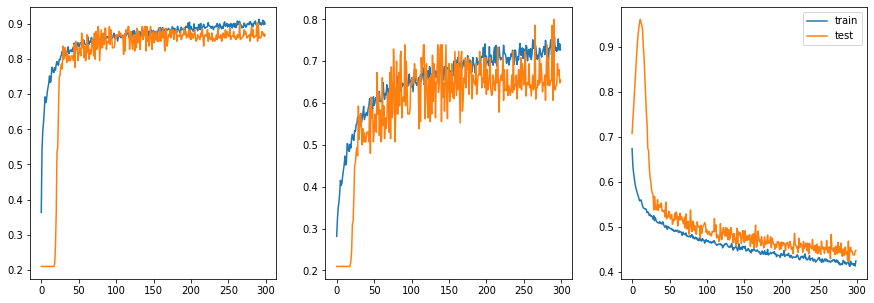

small_alexnet_adam_0.000001_weighted_f_48_192





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
169,fixed,weighted,100,48,192,0.857477,0.865116,0.637066,0.648148,0.854922,0.777778,165.0,35.0,569.0,151.0,94.0,19.0,28.0,10.0
170,fixed,weighted,150,48,192,0.877336,0.874419,0.681818,0.680000,0.854922,0.755556,165.0,34.0,586.0,154.0,77.0,16.0,28.0,11.0
171,fixed,weighted,200,48,192,0.882009,0.883721,0.690083,0.708333,0.865285,0.755556,167.0,34.0,588.0,156.0,75.0,14.0,26.0,11.0
172,fixed,weighted,250,48,192,0.891355,0.874419,0.706612,0.680000,0.886010,0.755556,171.0,34.0,592.0,154.0,71.0,16.0,22.0,11.0
173,fixed,weighted,300,48,192,0.900701,0.869767,0.726891,0.654545,0.896373,0.800000,173.0,36.0,598.0,151.0,65.0,19.0,20.0,9.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
24,gradual,weighted,96,128,768.521015,1581121,448
25,gradual,weighted,96,192,760.023650,2337601,576
26,gradual,weighted,96,256,807.826938,3099201,704
27,fixed,weighted,48,128,761.688048,795937,352
28,fixed,weighted,48,192,738.359314,1180705,480


{'name': 'weighted', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8808>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': {0: 0.6455505279034691, 1: 2.2176165803108807}}
small_alexnet_adam_0.000001_weighted_f_48_256


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_weighted_f_48_256\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_weighted_f_48_256\assets


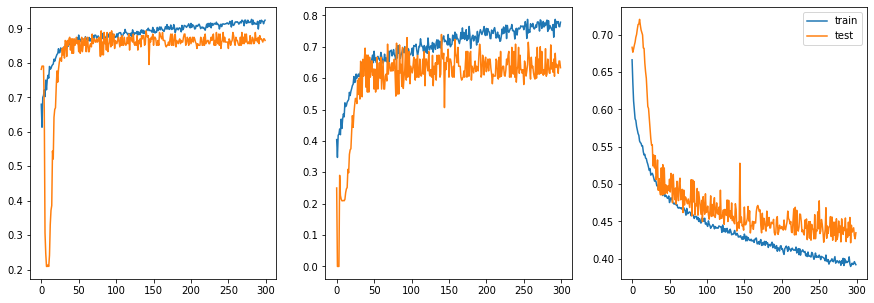

small_alexnet_adam_0.000001_weighted_f_48_256





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
175,fixed,weighted,100,48,256,0.873832,0.865116,0.674897,0.637931,0.849741,0.822222,164.0,37.0,584.0,149.0,79.0,21.0,29.0,8.0
176,fixed,weighted,150,48,256,0.903037,0.883721,0.739130,0.692308,0.880829,0.800000,170.0,36.0,603.0,154.0,60.0,16.0,23.0,9.0
177,fixed,weighted,200,48,256,0.901869,0.874419,0.735931,0.666667,0.880829,0.800000,170.0,36.0,602.0,152.0,61.0,18.0,23.0,9.0
178,fixed,weighted,250,48,256,0.915888,0.860465,0.766520,0.627119,0.901554,0.822222,174.0,37.0,610.0,148.0,53.0,22.0,19.0,8.0
179,fixed,weighted,300,48,256,0.924065,0.865116,0.778261,0.633333,0.927461,0.844444,179.0,38.0,612.0,148.0,51.0,22.0,14.0,7.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
25,gradual,weighted,96,192,760.023650,2337601,576
26,gradual,weighted,96,256,807.826938,3099201,704
27,fixed,weighted,48,128,761.688048,795937,352
28,fixed,weighted,48,192,738.359314,1180705,480
29,fixed,weighted,48,256,714.212458,1570593,608


{'name': 'weighted', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8808>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': {0: 0.6455505279034691, 1: 2.2176165803108807}}
small_alexnet_adam_0.000001_weighted_f_64_128


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_weighted_f_64_128\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_weighted_f_64_128\assets


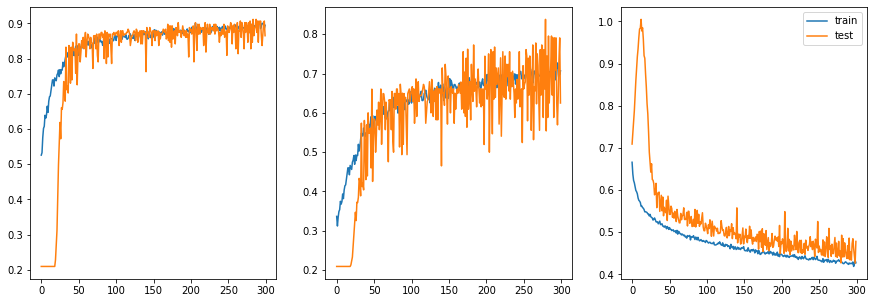

small_alexnet_adam_0.000001_weighted_f_64_128





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
181,fixed,weighted,100,64,128,0.863318,0.869767,0.643939,0.644068,0.880829,0.844444,170.0,38.0,569.0,149.0,94.0,21.0,23.0,7.0
182,fixed,weighted,150,64,128,0.859813,0.879070,0.636704,0.693878,0.880829,0.755556,170.0,34.0,566.0,155.0,97.0,15.0,23.0,11.0
183,fixed,weighted,200,64,128,0.884346,0.879070,0.683594,0.661017,0.906736,0.866667,175.0,39.0,582.0,150.0,81.0,20.0,18.0,6.0
184,fixed,weighted,250,64,128,0.885514,0.893023,0.692308,0.720000,0.886010,0.800000,171.0,36.0,587.0,156.0,76.0,14.0,22.0,9.0
185,fixed,weighted,300,64,128,0.894860,0.865116,0.706827,0.625000,0.911917,0.888889,176.0,40.0,590.0,146.0,73.0,24.0,17.0,5.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
26,gradual,weighted,96,256,807.826938,3099201,704
27,fixed,weighted,48,128,761.688048,795937,352
28,fixed,weighted,48,192,738.359314,1180705,480
29,fixed,weighted,48,256,714.212458,1570593,608
30,fixed,weighted,64,128,687.918747,1057665,384


{'name': 'weighted', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8808>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': {0: 0.6455505279034691, 1: 2.2176165803108807}}
small_alexnet_adam_0.000001_weighted_f_64_192


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_weighted_f_64_192\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_weighted_f_64_192\assets


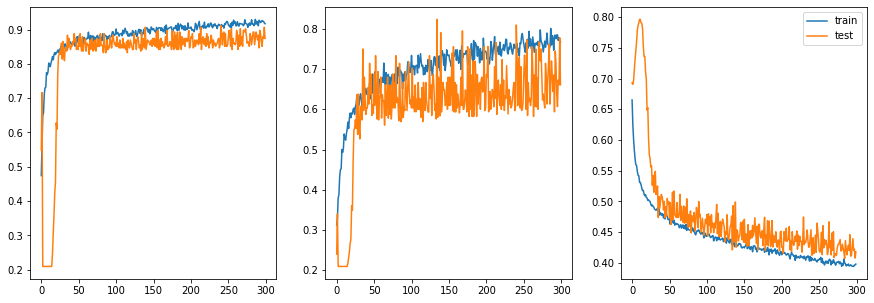

small_alexnet_adam_0.000001_weighted_f_64_192





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
187,fixed,weighted,100,64,192,0.886682,0.860465,0.701681,0.622951,0.865285,0.844444,167.0,38.0,592.0,147.0,71.0,23.0,26.0,7.0
188,fixed,weighted,150,64,192,0.899533,0.874419,0.733624,0.680000,0.870466,0.755556,168.0,34.0,602.0,154.0,61.0,16.0,25.0,11.0
189,fixed,weighted,200,64,192,0.904206,0.851163,0.744493,0.603175,0.875648,0.844444,169.0,38.0,605.0,145.0,58.0,25.0,24.0,7.0
190,fixed,weighted,250,64,192,0.921729,0.855814,0.773913,0.616667,0.922280,0.822222,178.0,37.0,611.0,147.0,52.0,23.0,15.0,8.0
191,fixed,weighted,300,64,192,0.917056,0.874419,0.767544,0.660714,0.906736,0.822222,175.0,37.0,610.0,151.0,53.0,19.0,18.0,8.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
27,fixed,weighted,48,128,761.688048,795937,352
28,fixed,weighted,48,192,738.359314,1180705,480
29,fixed,weighted,48,256,714.212458,1570593,608
30,fixed,weighted,64,128,687.918747,1057665,384
31,fixed,weighted,64,192,685.929808,1566337,512


{'name': 'weighted', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8808>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': {0: 0.6455505279034691, 1: 2.2176165803108807}}
small_alexnet_adam_0.000001_weighted_f_64_256


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_weighted_f_64_256\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_weighted_f_64_256\assets


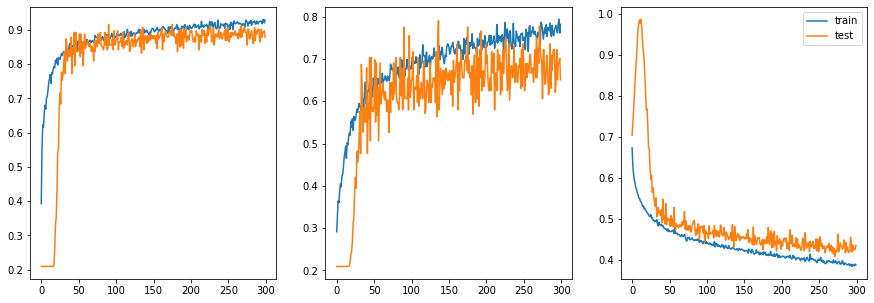

small_alexnet_adam_0.000001_weighted_f_64_256





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
193,fixed,weighted,100,64,256,0.878505,0.860465,0.675889,0.622951,0.886010,0.844444,171.0,38.0,581.0,147.0,82.0,23.0,22.0,7.0
194,fixed,weighted,150,64,256,0.904206,0.883721,0.734177,0.666667,0.901554,0.888889,174.0,40.0,600.0,150.0,63.0,20.0,19.0,5.0
195,fixed,weighted,200,64,256,0.910047,0.897674,0.739669,0.734694,0.927461,0.800000,179.0,36.0,600.0,157.0,63.0,13.0,14.0,9.0
196,fixed,weighted,250,64,256,0.912383,0.906977,0.743802,0.735849,0.932642,0.866667,180.0,39.0,601.0,156.0,62.0,14.0,13.0,6.0
197,fixed,weighted,300,64,256,0.928738,0.879070,0.782051,0.650794,0.948187,0.911111,183.0,41.0,612.0,148.0,51.0,22.0,10.0,4.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
28,fixed,weighted,48,192,738.359314,1180705,480
29,fixed,weighted,48,256,714.212458,1570593,608
30,fixed,weighted,64,128,687.918747,1057665,384
31,fixed,weighted,64,192,685.929808,1566337,512
32,fixed,weighted,64,256,678.310092,2080129,640


{'name': 'weighted', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8808>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': {0: 0.6455505279034691, 1: 2.2176165803108807}}
small_alexnet_adam_0.000001_weighted_f_96_128


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_weighted_f_96_128\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_weighted_f_96_128\assets


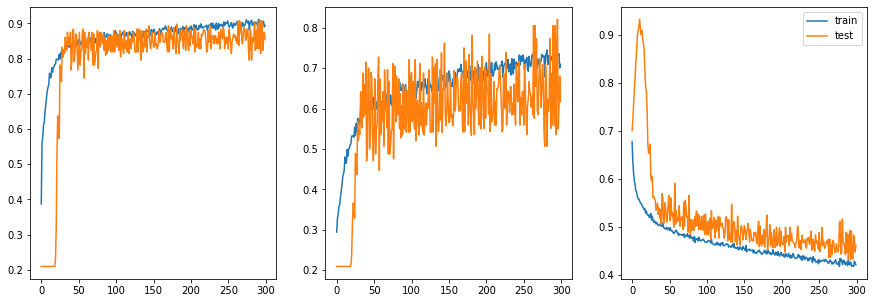

small_alexnet_adam_0.000001_weighted_f_96_128





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
199,fixed,weighted,100,96,128,0.878505,0.865116,0.680162,0.637931,0.870466,0.822222,168.0,37.0,584.0,149.0,79.0,21.0,25.0,8.0
200,fixed,weighted,150,96,128,0.871495,0.851163,0.666667,0.610169,0.860104,0.800000,166.0,36.0,580.0,147.0,83.0,23.0,27.0,9.0
201,fixed,weighted,200,96,128,0.885514,0.837209,0.693878,0.575758,0.880829,0.844444,170.0,38.0,588.0,142.0,75.0,28.0,23.0,7.0
202,fixed,weighted,250,96,128,0.906542,0.860465,0.732510,0.641509,0.922280,0.755556,178.0,34.0,598.0,151.0,65.0,19.0,15.0,11.0
203,fixed,weighted,300,96,128,0.893692,0.855814,0.709016,0.616667,0.896373,0.822222,173.0,37.0,592.0,147.0,71.0,23.0,20.0,8.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
29,fixed,weighted,48,256,714.212458,1570593,608
30,fixed,weighted,64,128,687.918747,1057665,384
31,fixed,weighted,64,192,685.929808,1566337,512
32,fixed,weighted,64,256,678.310092,2080129,640
33,fixed,weighted,96,128,683.978015,1581121,448


{'name': 'weighted', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8808>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': {0: 0.6455505279034691, 1: 2.2176165803108807}}
small_alexnet_adam_0.000001_weighted_f_96_192


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_weighted_f_96_192\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_weighted_f_96_192\assets


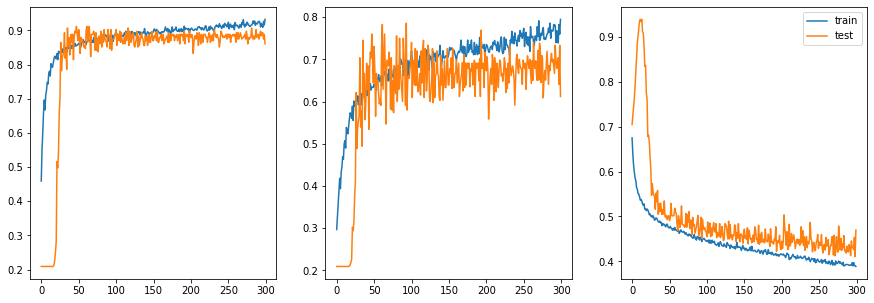

small_alexnet_adam_0.000001_weighted_f_96_192





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
205,fixed,weighted,100,96,192,0.890187,0.888372,0.702041,0.690909,0.891192,0.844444,172.0,38.0,590.0,153.0,73.0,17.0,21.0,7.0
206,fixed,weighted,150,96,192,0.893692,0.869767,0.705645,0.639344,0.906736,0.866667,175.0,39.0,590.0,148.0,73.0,22.0,18.0,6.0
207,fixed,weighted,200,96,192,0.901869,0.883721,0.724280,0.708333,0.911917,0.755556,176.0,34.0,596.0,156.0,67.0,14.0,17.0,11.0
208,fixed,weighted,250,96,192,0.917056,0.888372,0.762931,0.698113,0.917098,0.822222,177.0,37.0,608.0,154.0,55.0,16.0,16.0,8.0
209,fixed,weighted,300,96,192,0.932243,0.860465,0.794760,0.611940,0.943005,0.911111,182.0,41.0,616.0,144.0,47.0,26.0,11.0,4.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
30,fixed,weighted,64,128,687.918747,1057665,384
31,fixed,weighted,64,192,685.929808,1566337,512
32,fixed,weighted,64,256,678.310092,2080129,640
33,fixed,weighted,96,128,683.978015,1581121,448
34,fixed,weighted,96,192,700.787551,2337601,576


{'name': 'weighted', 'loss': <keras.losses.BinaryCrossentropy object at 0x000002C4AACA8808>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AAC72848>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000002C4AA9DAD48>, 'cweights': {0: 0.6455505279034691, 1: 2.2176165803108807}}
small_alexnet_adam_0.000001_weighted_f_96_256


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_weighted_f_96_256\assets


INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_weighted_f_96_256\assets


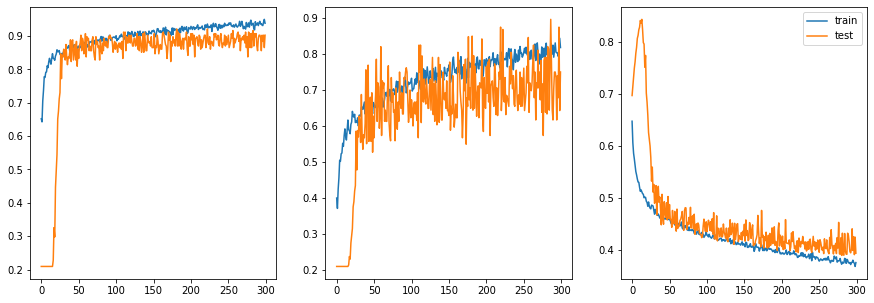

small_alexnet_adam_0.000001_weighted_f_96_256





-------------------------------------------


,optimizer,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision,recall,val_recall,tp,val_tp,tn,val_tn,fp,val_fp,fn,val_fn
211,fixed,weighted,100,96,256,0.893692,0.860465,0.721739,0.622951,0.860104,0.844444,166.0,38.0,599.0,147.0,64.0,23.0,27.0,7.0
212,fixed,weighted,150,96,256,0.913551,0.865116,0.753191,0.642857,0.917098,0.800000,177.0,36.0,605.0,150.0,58.0,20.0,16.0,9.0
213,fixed,weighted,200,96,256,0.920561,0.869767,0.765957,0.649123,0.932642,0.822222,180.0,37.0,608.0,150.0,55.0,20.0,13.0,8.0
214,fixed,weighted,250,96,256,0.934579,0.888372,0.796537,0.705882,0.953368,0.800000,184.0,36.0,616.0,155.0,47.0,15.0,9.0,9.0
215,fixed,weighted,300,96,256,0.938084,0.902326,0.818182,0.750000,0.932642,0.800000,180.0,36.0,623.0,158.0,40.0,12.0,13.0,9.0


,optimizer,data,filter1,filter2,time,train_parameters,nontrain_parameters
31,fixed,weighted,64,192,685.929808,1566337,512
32,fixed,weighted,64,256,678.310092,2080129,640
33,fixed,weighted,96,128,683.978015,1581121,448
34,fixed,weighted,96,192,700.787551,2337601,576
35,fixed,weighted,96,256,751.466157,3099201,704


In [8]:
column_names = ['optimizer','data', 'step', 'filter1', 'filter2','accuracy', 'val_accuracy', 'precision', 'val_precision', 
                'recall', 'val_recall', 'tp', 'val_tp', 'tn', 'val_tn', 'fp', 'val_fp', 'fn', 'val_fn']
data = pd.DataFrame(columns=column_names)

column_info = ['optimizer', 'data', 'filter1', 'filter2', 'time', 'train_parameters', 'nontrain_parameters']
data_info = pd.DataFrame(columns=column_info)

metrics = [
      "accuracy", 
      keras.metrics.Precision(name='precision'), 
      keras.metrics.Recall(name='recall'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.FalseNegatives(name='fn'),
    ]

for loss in losses:
    for optimizer in optimizers:
        for f1 in filters1:
            for f2 in filters2:
                
                if optimizer['name']=='adam_exponential':
                    lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=25,decay_rate=0.8)
                    adam = keras.optimizers.Adam(learning_rate=lr_schedule)
                else:
                    adam = optimizer['opt']
        
                print(loss)
                f_name = 'small_alexnet_'+optimizer['name']+'_'+loss['name']+'_f_'+str(f1)+'_'+str(f2)
                print(f_name)

                keras.backend.clear_session()
                model = get_model('relu',f1, f2)

                trainable_count = count_params(model.trainable_weights)
                non_trainable_count = count_params(model.non_trainable_weights)

                model.compile(loss = loss['loss'], optimizer = adam, metrics=metrics)#, "categorical_accuracy"])
                start = time()
                h = model.fit(loss['train'],
                          epochs=epochs,
                          validation_data=loss['val'],
                          validation_freq=1,
                          class_weight=loss['cweights'],
                            verbose=False)
                train_time = time()-start

                df_historic = pd.DataFrame(h.history)
                df_historic.to_csv('results/'+f_name+'.csv')
                model.save('results/'+f_name)

                fig, ax = plt.subplots(1,3, figsize=(15, 5))

                ax[0].plot(df_historic['accuracy'].values, label='acc')
                ax[0].plot(df_historic['val_accuracy'].values, label='val_acc')
                ax[1].plot(df_historic['precision'].values)
                ax[1].plot(df_historic['val_precision'].values)
                ax[2].plot(df_historic['loss'].values, label='train')
                ax[2].plot(df_historic['val_loss'].values, label='test')
                plt.legend()

                plt.show()
                print(f_name)

                for i in range(5):
                    print()
                print('-------------------------------------------')


                for i in range(step,epochs+1,step):                            
                    results = [
                        optimizer['id'],
                        loss['name'],
                        i,
                        f1,
                        f2,
                        df_historic['accuracy'].values[i-1], 
                        df_historic['val_accuracy'].values[i-1], 
                        df_historic['precision'].values[i-1],
                        df_historic['val_precision'].values[i-1],
                        df_historic['recall'].values[i-1], 
                        df_historic['val_recall'].values[i-1], 
                        df_historic['tp'].values[i-1],
                        df_historic['val_tp'].values[i-1],
                        df_historic['tn'].values[i-1], 
                        df_historic['val_tn'].values[i-1], 
                        df_historic['fp'].values[i-1],
                        df_historic['val_fp'].values[i-1],
                        df_historic['fn'].values[i-1],
                        df_historic['val_fn'].values[i-1],
                    ]

                    data = data.append(dict(zip(column_names,results)), ignore_index=True)
                display(data.tail())

                info = [optimizer['id'],loss['name'], f1,f2, train_time, trainable_count, non_trainable_count]
                data_info = data_info.append(dict(zip(column_info,info)), ignore_index=True)

                display(data_info.tail())
data.to_csv('results/results.csv', index=False)
data_info.to_csv('results/info.csv', index=False)